In [ ]:
#!pip install torch torchvision

import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


np.random.seed(1234)
torch.manual_seed(1234)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Found device : {device}")

Found device : cuda


In [ ]:
# When we load the data, they exist as as PIL images, convert to tensors, cell values are in [0, 1] so we don't need to normalize them.
transform = transforms.Compose([transforms.ToTensor()])

# load dataset
data_folder = "./fashionMNIST"
train_data = torchvision.datasets.FashionMNIST(data_folder, train=True, download=True, transform=transform)
test_data  = torchvision.datasets.FashionMNIST(data_folder, train=False, download=True, transform=transform)

# split training data into training and validation sets
train_data, valid_data = torch.utils.data.random_split(train_data, [50000,10000]) # 50k train, 10k validation

batch_size =1000
# data iterators
train_set  = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_set  = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_set   = torch.utils.data.DataLoader(test_data,  shuffle=False, batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:02<00:00, 12020680.80it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202609.95it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3760827.21it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7228750.25it/s]

Extracting ./fashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



In [ ]:
# define the model

class EncoderDeep(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeep, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4_mean = nn.Linear(250, n_components)
        self.fc4_std = nn.Linear(250, n_components)

    def forward(self, x):
        x = x.view(-1, 1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc4_mean(x)
        std = self.fc4_std(x)
        return mu, std


class DecoderDeep(nn.Module):
    def __init__(self, n_components):
        super(DecoderDeep, self).__init__()
        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) # self.fc4(x)#
        x = x.view(-1, 1, 28, 28)
        return x


def reparameterize(mu, std):
    """
    Take in mean and log(standard deviation) of a Normal distribution,
    and output a n_samples from the corresponding gaussian.
    """
    z_samples = torch.randn_like(mu)
    rep_samples = std*z_samples + mu
    return rep_samples

In [ ]:
# training stuff
n_components = 2 # 2 dimensional latent space
encoder = EncoderDeep(n_components=n_components)
decoder = DecoderDeep(n_components=n_components)

encoder = encoder.cuda()
decoder = decoder.cuda()

params = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(params=params, lr=1e-3)

criterion = nn.BCELoss(reduction='sum')


In [ ]:
n_epochs = 30

encoder.train()
decoder.train()

kl_losses    = []
recon_losses = []
elbo         = []
for epoch in range(n_epochs):
    kl_  = []
    rec_ = []
    elbo_= []
    for data, label in train_set:
        data = data.cuda()
        optimizer.zero_grad()

        z_means, z_stds = encoder(data)
        z_stds = torch.exp(z_stds)

        z = reparameterize(z_means, z_stds)
        x = decoder(z)
        loss_reconstruction = criterion(x, data)/batch_size

        # https://ai.stackexchange.com/questions/26366/how-is-this-pytorch-expression-equivalent-to-the-kl-divergence
        loss_kl = -torch.mean(0.5*torch.sum(1 - torch.pow(z_stds,2) - torch.pow(z_means,2) + torch.log(torch.pow(z_stds,2)), dim=-1))

        loss = loss_reconstruction + loss_kl

        loss.backward()
        optimizer.step()

        kl_.append(loss_kl.item())
        rec_.append(loss_reconstruction.item())
        elbo_.append(loss.item())

    kl_losses.append(np.mean(kl_))
    recon_losses.append(np.mean(rec_))
    elbo.append(np.mean(elbo_))
    print("Epoch {:3d}  Reconstruction Loss {:7>.7f} KL loss {:7>.7f}, ELBO {:7>.7f}".format(epoch, recon_losses[-1], kl_losses[-1], elbo[-1]))

Epoch   0  Reconstruction Loss 256.2007593 KL loss 6.2572956, ELBO 262.4580542
Epoch   1  Reconstruction Loss 255.4997406 KL loss 6.2817674, ELBO 261.7815094
Epoch   2  Reconstruction Loss 254.9496481 KL loss 6.2761706, ELBO 261.2258170
Epoch   3  Reconstruction Loss 254.2786102 KL loss 6.3025808, ELBO 260.5811902
Epoch   4  Reconstruction Loss 253.8935043 KL loss 6.3178995, ELBO 260.2114044
Epoch   5  Reconstruction Loss 253.7496497 KL loss 6.3250796, ELBO 260.0747290
Epoch   6  Reconstruction Loss 253.2723267 KL loss 6.3305334, ELBO 259.6028619
Epoch   7  Reconstruction Loss 252.8200110 KL loss 6.3534005, ELBO 259.1734128
Epoch   8  Reconstruction Loss 252.5256296 KL loss 6.3811697, ELBO 258.9067990
Epoch   9  Reconstruction Loss 252.0061740 KL loss 6.3769779, ELBO 258.3831525
Epoch  10  Reconstruction Loss 251.7801895 KL loss 6.3996613, ELBO 258.1798505
Epoch  11  Reconstruction Loss 251.5966110 KL loss 6.4097859, ELBO 258.0063977
Epoch  12  Reconstruction Loss 251.5345340 KL loss 6

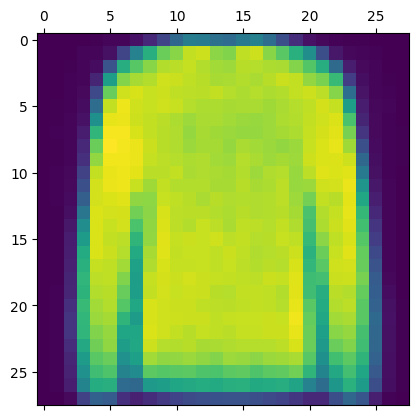

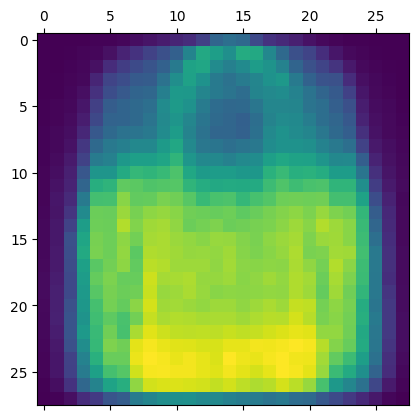

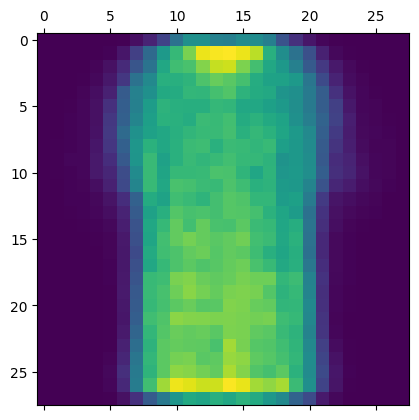

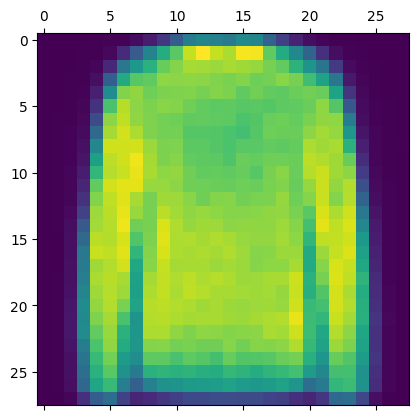

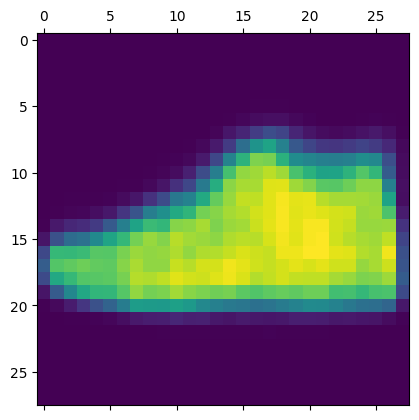

In [ ]:
for i in range(5):
    plt.matshow(x[i].detach().cpu().numpy().reshape(28,28))

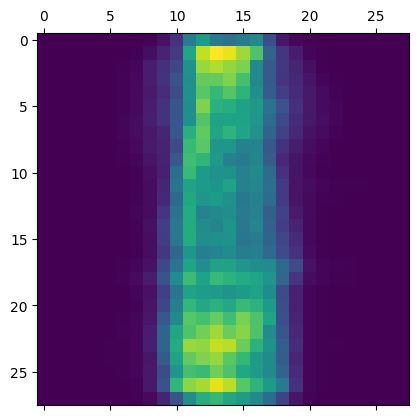

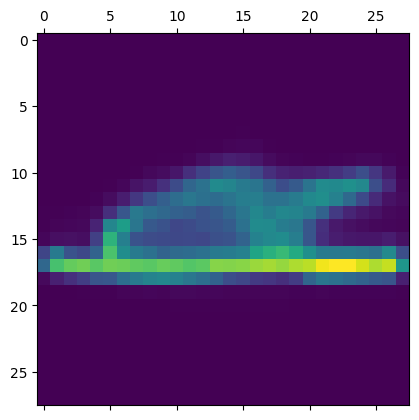

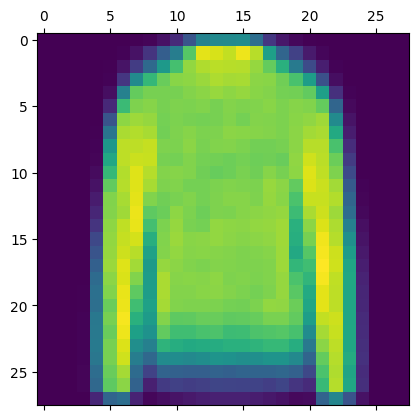

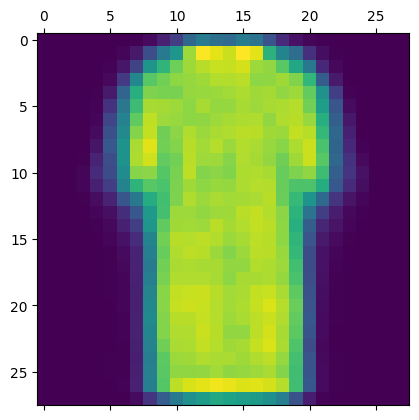

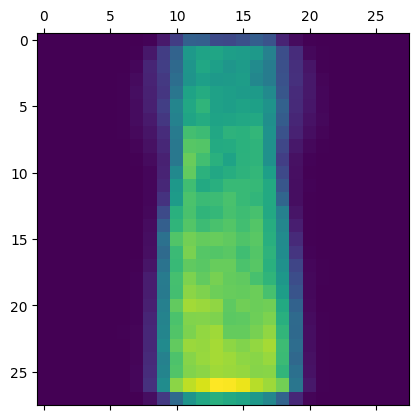

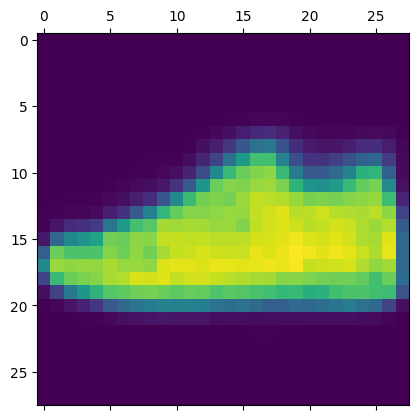

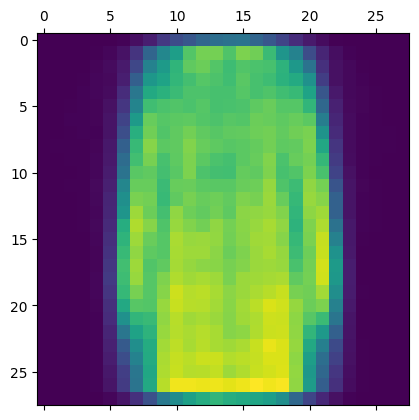

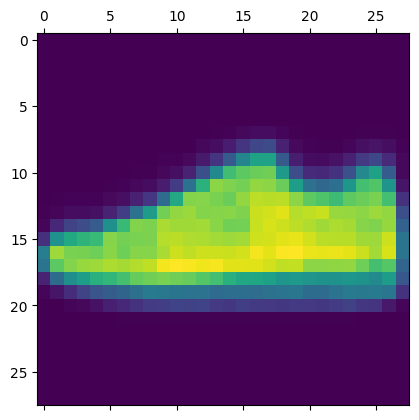

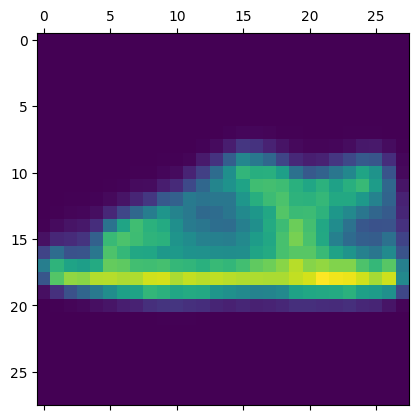

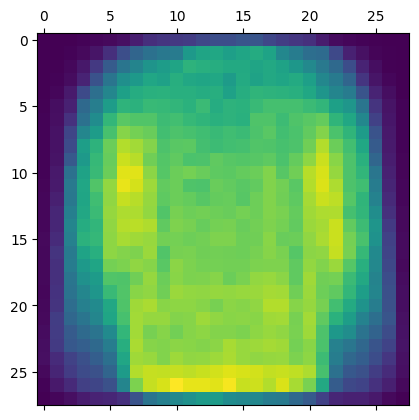

In [ ]:
z_new = torch.randn_like(z_means)
x_new = decoder(z_new)
for i in range(10):
    plt.matshow(x_new[i].detach().cpu().numpy().reshape(28,28))


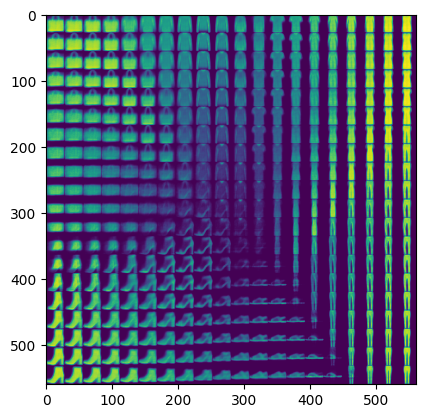

In [ ]:
x = np.linspace(-2,2,20)
y = np.linspace(-1,1,20)
X,Y = np.meshgrid(x,y)
z_grid = np.hstack((X.reshape(400,1), Y.reshape(400,1)))
z_grid = torch.from_numpy(z_grid).float()
z_grid = z_grid

new_decoder = decoder.cpu()
x_new = new_decoder(z_grid)

def convert_to_oneimage(x_new):
    """
    x_new is assumed to be n_row**2, 1, width, height
    concretely, (100, 1, 28, 28) so 100 images of 28,28
    """
    n_rows = int(np.sqrt(x_new.shape[0]))
    w,h = x_new.shape[2], x_new.shape[3]
    new_img = np.zeros((n_rows*w, n_rows*h))

    for row in range(n_rows):
        for col in range(n_rows):
            new_img[row*w:row*w+w,col*h:col*h+h] = x_new[row*n_rows+col].reshape(w,h)
    plt.imshow(new_img)

convert_to_oneimage(x_new.detach().numpy())